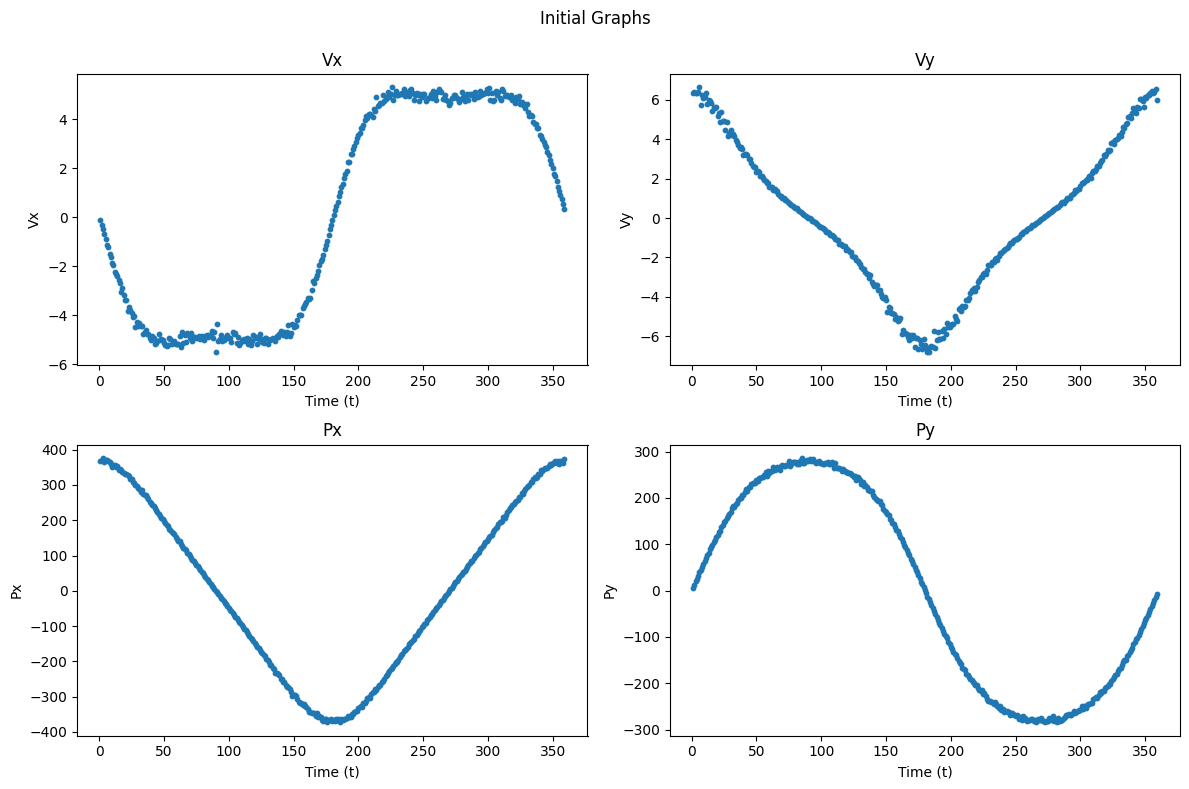

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data from 'kalmann.txt'
df = pd.read_table('kalmann.txt', sep=',')
df = df.reset_index()
df.columns = ['Px', 'Py', 'Vx', 'Vy']

# Create a 't' column as an index
df['t'] = df.index + 1

# Create subplots for each graph
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Initial Graphs')

# Plot Vx
axs[0, 0].scatter(df['t'], df['Vx'], s=10)
axs[0, 0].set_title('Vx')
axs[0, 0].set_xlabel('Time (t)')
axs[0, 0].set_ylabel('Vx')

# Plot Vy
axs[0, 1].scatter(df['t'], df['Vy'], s=10)
axs[0, 1].set_title('Vy')
axs[0, 1].set_xlabel('Time (t)')
axs[0, 1].set_ylabel('Vy')

# Plot Px
axs[1, 0].scatter(df['t'], df['Px'], s=10)
axs[1, 0].set_title('Px')
axs[1, 0].set_xlabel('Time (t)')
axs[1, 0].set_ylabel('Px')

# Plot Py
axs[1, 1].scatter(df['t'], df['Py'], s=10)
axs[1, 1].set_title('Py')
axs[1, 1].set_xlabel('Time (t)')
axs[1, 1].set_ylabel('Py')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


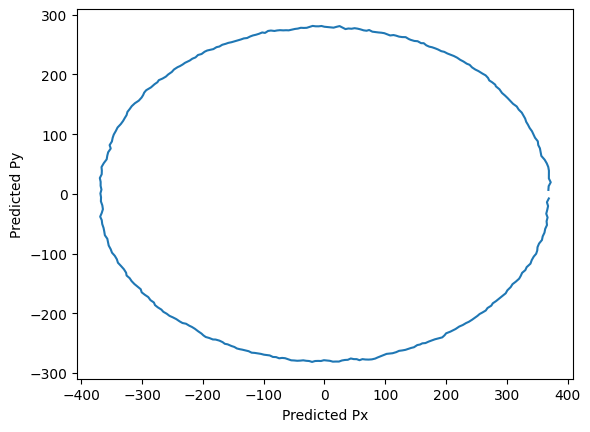

In [6]:
# Define initial covariance matrix P
P = np.array([[30, 0, 0, 0],
              [0, 30, 0, 0],
              [0, 0, 0.3, 0],
              [0, 0, 0, 0.3]])

# Define state transition matrix A
A = np.array([[1, 0, 1, 0],
              [0, 1, 0, 1],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])

# Define control matrix B
B = np.array([[0.5, 0],
              [0, 0.5],
              [1, 0],
              [0, 1]])

# Calculate acceleration in X and Y direction
df['ax'] = df['Vx'].diff().fillna(0)
df['ay'] = df['Vy'].diff().fillna(0)

# Define measurement error covariance matrix R
R = np.array([[40, 0, 0, 0],
              [0, 40, 0, 0],
              [0, 0, 0.5, 0],
              [0, 0, 0, 0.5]])

# Define measurement matrix H
H = np.identity(4)

# Initialize the prediction DataFrame
pred = df.copy()

# Initialize the prediction DataFrame with P values
pred = df.copy()
pred['p1'] = 30  # Initial P values for Px
pred['p2'] = 30  # Initial P values for Py
pred['p3'] = 0.3  # Initial P values for Vx
pred['p4'] = 0.3  # Initial P values for Vy

# Perform the Kalman filter process
for i in range(1, 359):
    Xk = np.array([[df.loc[i, 'Px']], [df.loc[i, 'Py']], [df.loc[i, 'Vx']], [df.loc[i, 'Vy']]])
    Xj = np.array([[pred.loc[i - 1, 'Px']], [pred.loc[i - 1, 'Py']], [pred.loc[i - 1, 'Vx']], [pred.loc[i - 1, 'Vy']]])
    uk = np.array([[df.loc[i, 'ax']], [df.loc[i, 'ay']]])
    Xkp = A @ Xj + B @ uk
    Pj = np.diag([pred.loc[i - 1, f'p{i}'] for i in range(1, 5)])
    Pk = A @ Pj @ A.T
    S = H @ Pk @ H.T + R
    K = Pk @ H.T @ np.linalg.inv(S)
    Ab = Xkp + K @ (Xk - H @ Xkp)
    pred.loc[i, 'Px'] = Ab[0, 0]
    pred.loc[i, 'Py'] = Ab[1, 0]
    pred.loc[i, 'Vx'] = Ab[2, 0]
    pred.loc[i, 'Vy'] = Ab[3, 0]
    Pk = (np.identity(4) - K @ H) @ Pk
    for j in range(1, 5):
        pred.loc[i, f'p{j}'] = Pk[j - 1, j - 1]


# Plot the predicted path
plt.plot(pred.Px, pred.Py)
plt.xlabel('Predicted Px')
plt.ylabel('Predicted Py')
plt.show()

# Save the predicted data to a CSV file
pred.to_csv('kalman_prediction.csv')


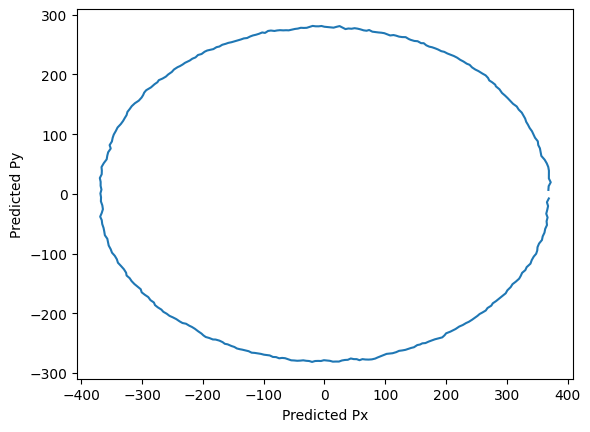

18.87611099367906
18.87611099367907
[[5.87728039e+04 5.13386099e+04 1.05328152e+03 9.06621864e+02]
 [5.13386099e+04 4.48447699e+04 9.20051550e+02 7.91942925e+02]
 [1.05328152e+03 9.20051550e+02 1.88761110e+01 1.62477880e+01]
 [9.06621864e+02 7.91942925e+02 1.62477880e+01 1.39854346e+01]]
[[ 5.87728039e+04  4.63306291e+01  7.09378745e+00  8.98605049e+02]
 [ 4.63306291e+01  4.48447699e+04 -9.09408356e+02  6.95145640e+00]
 [ 7.09378745e+00 -9.09408356e+02  1.88761110e+01 -1.06629634e-02]
 [ 8.98605049e+02  6.95145640e+00 -1.06629634e-02  1.39854346e+01]]


In [7]:
# Plot the predicted path
plt.plot(pred.Px, pred.Py)
plt.xlabel('Predicted Px')
plt.ylabel('Predicted Py')
plt.show()

# Save the predicted data to a CSV file
pred.to_csv('kalman_prediction.csv')

# Calculate Q matrix elements
q1 = df['Px'].std()
q2 = df['Py'].std()
q3 = df['Vx'].std()
q4 = df['Vy'].std()
q5, q6, q7, q8, q9, q10, q11 = 0, 0, 0, 0, 0, 0, 0

for i in range(0, 359):
    q5 += (df.Px.mean() - df.loc[i, 'Px']) * (df.Py.mean() - df.loc[i, 'Py']) / 358
    q6 += (df.Px.mean() - df.loc[i, 'Px']) * (df.Vx.mean() - df.loc[i, 'Vx']) / 358
    q7 += (df.Px.mean() - df.loc[i, 'Px']) * (df.Vy.mean() - df.loc[i, 'Vy']) / 358
    q8 += (df.Vx.mean() - df.loc[i, 'Vx']) * (df.Py.mean() - df.loc[i, 'Py']) / 358
    q9 += (df.Vy.mean() - df.loc[i, 'Vy']) * (df.Py.mean() - df.loc[i, 'Py']) / 358
    q10 += (df.Vx.mean() - df.loc[i, 'Vx']) * (df.Vy.mean() - df.loc[i, 'Vy']) / 359
    q11 += (df.Vx.mean() - df.loc[i, 'Vx']) * (df.Vx.mean() - df.loc[i, 'Vx']) / 358

print(q11)
print(q3 * q3)

N1 = np.array([[q1 * q1, q1 * q2, q1 * q3, q1 * q4],
               [q1 * q2, q2 * q2, q2 * q3, q2 * q4],
               [q1 * q3, q2 * q3, q3 * q3, q4 * q3],
               [q4 * q1, q4 * q2, q4 * q3, q4 * q4]])

print(N1)

N = np.array([[q1 * q1, q5, q6, q7],
              [q5, q2 * q2, q8, q9],
              [q6, q8, q3 * q3, q10],
              [q7, q9, q10, q4 * q4]])

print(N)
